In [125]:
import pandas as pd

In [126]:
df=pd.read_csv("salary_indeed.csv")

In [127]:
df["Salary"][0]

nan

In [128]:
df['Title'].unique().tolist()

['Développeuse / Développeur Stack Elastic Search',
 'Développeur Front End F/H',
 'Data Analyst (H/F) - Alternance',
 "INTERNSHIP POSITION, Evaluation of the aircraft data traffic's cost (m/f)",
 'Des Développeurs Java JEE (H/F)',
 'LEAD DEVELOPPEUR PYTHON F/H',
 'Consultant Confirmé BI / Data Intelligence (H/F)',
 'Consultant Data (h/f)',
 'INGÉNIEUR DÉVELOPPEUR C++ / JAVA F/H',
 'Devops – Spécialiste Openstack H/F',
 'Développeur Web et Bases de Données F/H',
 'Data Engineer - Java 8 - H/F',
 'DEVOPS junior Data Management Middleware F/H',
 'INGENIEUR DEVELOPPEUR FIRMWARE',
 'Data Engineer - Santé',
 'Devops F/H',
 'Développeur Angular & C# H/F',
 'Data Scientist H/F',
 'Cloud Data Architect Manager – Secteur de la santé (H/F)',
 'BUSINESS DEVELOPER BTOB - DATA INTELLIGENCE (H/F)',
 'DATA MANAGER EXPERIMENTE',
 'Développeur Angular H/F',
 'Développeurs FrontEnd - AngularJs | iOs | Android - DevOps',
 'ANALYSTE DEVELOPPEUR WEB (H/F)',
 'Staff Data Engineer',
 'Développeur PHP / Consu

In [129]:
df["Salary"].fillna("None", inplace = True) # Je remplace les missing value par la string none

In [130]:
df.shape

(4884, 9)

# Création Fonction Split_city

On sépare la ville et le cp. On remplace les differents arrondisements de Paris et Lyon par la ville. On remplis les valeurs manquantes par le départment de recherche

In [131]:
def split_city(row):
    location = row["Location"]
    if "Paris" in location or location == "France":
        city = "Paris"
        code_postal = "75"
    elif "Lyon" in location:
        city = "Lyon"
        code_postal = "69"
    elif "(" in location:
        split = location.split("(")
        city = split[0]
        code_postal = split[1]
    else:
        city = row["Department_Search"]
        code_postal="None"
    
    row["city"] = city
    row["cp"] = code_postal.replace(")","")
    return row

# Création colonne city et cp

In [132]:
df = df.apply(split_city, axis=1)

# Création Fonction Split Salary

Création des colonnes salaire_max, salaire_min et type de salaire. On transforme en annuelle seulement les valeurs en mois qui sont supérieur à 1500 smic brut + création de la colonne type de salaire (annuelle, mensuelle, hebdomadaire et par heure)

In [170]:
def split_salary(row):
    salary = row["Salary"]
    if "-" in salary:
        split = salary.split("-")
        salary_min = split[0]
        salary_max = split[1]
    else:
        salary_min = salary
        salary_max = salary
    
    row["salary_min"] = salary_min.replace("€","").replace("par heure","").replace("par mois","").replace("par semaine","").replace("par an","").replace(",50",".50").replace("\xa0","")
    row["salary_max"] = salary_max.replace("€","").replace("par heure","").replace("par jour","").replace("par mois","").replace("par semaine","").replace(",50",".50").replace("par an","").replace("\xa0","")
    
    
    if ("mois" in row["Salary"]) and (int(row["salary_min"]) > 1500):
        row["salary_min"] = int(row["salary_min"])*12
        row["salary_max"] = int(row["salary_max"])*12
        row["salary_type"] = "annually"
    
    if "mois" in row["Salary"] and (int(row["salary_min"]) <= 1500):
        row["salary_type"] = "monthly"
        
    if "jour" in row["Salary"]:
        row["salary_type"] = "daily"
    
    if "semaine" in row["Salary"]:
        row["salary_type"] = "weekly"
        
    if "an" in row["Salary"]:
        row["salary_type"] = "annually"
    
    if "heure" in row["Salary"]:
        row["salary_type"] = "per hour"
        
    return row

# Création des colonnes salary max, salary min et salary type

In [171]:
df_salary = df[df["Salary"] != "None"]
df_salary = df_salary.apply(split_salary, axis=1)
df_salary["salary_min"]=pd.to_numeric(df_salary["salary_min"],'coerce')
df_salary["salary_max"]=pd.to_numeric(df_salary["salary_max"],'coerce')

In [172]:
df_salary

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_type
8,p_008d77a008590232,INGÉNIEUR DÉVELOPPEUR C++ / JAVA F/H,ALTEN,Toulouse (31),30 000 € - 45 000 € par an,Partenaire technologique de référence des plus...,08/09/2019,Développeur,Haute-Garonne,Toulouse,31,30000.0,45000.0,annually
15,p_00f2ad8db3c30b8e,Devops F/H,Kent FR,Bordeaux (33),35 000 € - 40 000 € par an,"KENT, marque de GroupAgora dédiée aux recrutem...",09/03/2019,Développeur,Gironde,Bordeaux,33,35000.0,40000.0,annually
17,p_00fa03a21ad52a71,Data Scientist H/F,QYSY,Paris (75),40 000 € - 65 000 € par an,QYSY est un cabinet de conseil et de recruteme...,29/09/2019,Data,75,Paris,75,40000.0,65000.0,annually
19,p_0130bef769eef3cc,BUSINESS DEVELOPER BTOB - DATA INTELLIGENCE (H/F),L.I.P,Lyon 3e (69),35 000 € - 60 000 € par an,69003 - Lyon-3e-Arrondissement CDI Bac+5 et pl...,07/10/2019,Data,Rhône,Lyon,69,35000.0,60000.0,annually
31,p_019d01b7494dc632,Référent fonctionnel et données - Data manager...,GARCIN FINANCES ET PARTICIPATIONS,Corbas (69),40 000 € - 45 000 € par an,Vous souhaitez participer à la structuration d...,10/09/2019,Data,Rhône,Corbas,69,40000.0,45000.0,annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871,pj_f9b2d5fe629ccfb3,DevOps (H/F),EASY PARTNER,Paris (75),50 000 € - 55 000 € par an,### LE POSTE Afin d’accompagner sa forte croi...,08/10/2019,Développeur,75,Paris,75,50000.0,55000.0,annually
4875,pj_fc87c600387c3e85,Developpeur Java Back-end,Gentis Recruitment SAS,Paris (75),50 € par heure,"Bonjour, Notre client est une startup, jeune ...",NaN,Développeur,75,Paris,75,50.0,50.0,per hour
4876,pj_fd8e78ca8bedfe98,Web Developpeur,CLERE / JES,Loire-Atlantique,22 000 € - 28 000 € par an,"Éditeur de logiciels, nous développons en inte...",NaN,Développeur,Loire-Atlantique,Loire-Atlantique,None,22000.0,28000.0,annually
4877,pj_fe470d6a829fdecc,Consultant Devops - H/F,Des Systèmes et des Hommes,Paris 9e (75),45 000 € par an,Docker / Hibernate / Linux / Jenkins / Oracle-...,NaN,Développeur,75,Paris,75,45000.0,45000.0,annually


In [173]:
print("Nombre de lignes avec salaire en années : {}".format(df_salary[df_salary["salary_type"]=="annually"].shape[0]))
print("Nombre de lignes avec salaire en mois : {}".format(df_salary[df_salary["salary_type"]=="monthly"].shape[0]))
print("Nombre de lignes avec salaire en semaine : {}".format(df_salary[df_salary["salary_type"]=="weekly"].shape[0]))
print("Nombre de lignes avec salaire en heure : {}".format(df_salary[df_salary["salary_type"]=="per hour"].shape[0]))

Nombre de lignes avec salaire en années : 675
Nombre de lignes avec salaire en mois : 30
Nombre de lignes avec salaire en semaine : 23
Nombre de lignes avec salaire en heure : 9


In [174]:
df_salary[df_salary["salary_type"]=="monthly"] # visualisation lignes saliare mensuelle

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_type
339,p_11932114a525d757,STAGE Chef de projet - Customer Data Managemen...,Danone,Limonest (69),1 120 € par mois,Danone recherche un(e) STAGE Chef de projet - ...,06/10/2019,Data,Rhône,Limonest,69,1120.0,1120.0,monthly
358,p_13477b94e2936148,Stage software et Data Engineer,Outmind,Paris 8e (75),600 € - 1 200 € par mois,À propos Outmind est une jeune startup créant ...,07/09/2019,Data,75,Paris,75,600.0,1200.0,monthly
599,p_21fa7fcf997add98,Stagiaire Stage Développeur/se web FRONT ou BACK,ITALIC,Paris 10e (75),700 € - 900 € par mois,"Récapitulatif du poste Le studio ITALIC , créé...",18/09/2019,Développeur,75,Paris,75,700.0,900.0,monthly
721,p_283edb6188ab0e56,Analyste développeur H/F,TMDS,Irigny (69),600 € - 1 000 € par mois,Stage QA Tester Pourquoi venir chez nous ? Tot...,04/10/2019,Développeur,Rhône,Irigny,69,600.0,1000.0,monthly
855,p_2f2cf27029d2954b,STAGIAIRE DEVELOPPEUR FRONT-END (H/F),LEOO,Paris (75),560 € par mois,"SOCIETE LEOO, filiale du groupe ADLPerformance...",07/09/2019,Développeur,75,Paris,75,560.0,560.0,monthly
895,p_31d61797124bb736,Data Analyst - Stage,Pretto,Paris (75),800 € - 1 200 € par mois,Dans une startup qui croît et se structure à t...,05/10/2019,Data,75,Paris,75,800.0,1200.0,monthly
1305,p_4adf45bdd9431ed7,"Data engineer (Oracle, SQL) / Freelance",Thiveo,Paris (75),600 € par mois,Mettre en uvre des solutions techniques sécur...,07/09/2019,Data,75,Paris,75,600.0,600.0,monthly
1377,p_4f36493edf4833b5,Stage - Développeur ASP.NET / C# (H/F),Aidimpact,Toulouse (31),580 € par mois,Développeur C# .NET Dans le cadre de notre cro...,27/09/2019,Développeur,Haute-Garonne,Toulouse,31,580.0,580.0,monthly
1402,p_50fd489da08f1f55,Développeur Web (stage) H/F,Blent.ai,Paris 3e (75),700 € par mois,Blent.ai est une startup spécialisée dans la...,07/10/2019,Développeur,75,Paris,75,700.0,700.0,monthly
1518,p_57f4a3ee1f4b1fd5,stage ingénieur - développeur,Certilience,Limonest (69),600 € - 850 € par mois,Résumé Environnement Vos missions Votre profil...,06/02/2019,Développeur,Rhône,Limonest,69,600.0,850.0,monthly


## Creation df par type de salaire

In [175]:
df_annually = df_salary[df_salary["salary_type"]=="annually"]
df_monthly = df_salary[df_salary["salary_type"]=="monthly"]
df_weekly = df_salary[df_salary["salary_type"]=="weekly"]
df_hour = df_salary[df_salary["salary_type"]=="per hour"]

## Création colonne salary mean pour chaque df

In [177]:
df_annually["salary_mean"] = (df_annually["salary_min"]+df_annually["salary_max"])/2
df_monthly["salary_mean"] = (df_monthly["salary_min"]+df_monthly["salary_max"])/2
df_weekly["salary_mean"] = (df_weekly["salary_min"]+df_weekly["salary_max"])/2
df_hour["salary_mean"] = (df_hour["salary_min"]+df_hour["salary_max"])/2

/Users/Ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [178]:
df_hour

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_type,salary_mean
804,p_2c741ebd774063de,Concepteur Développeur Java Jee F/H,Orkeis,Nantes (44),30 € - 37 € par heure,"Intégré(e) au sein d’une équipe IT, vous inter...",08/12/2018,Développeur,Loire-Atlantique,Nantes,44,30.0,37.0,per hour,33.5
4358,pj_0af9a47690300a4f,Analyste d’exploitation informatique DevOps,NOVA TECHNOLOGY,Nantes (44),32 € - 35 € par heure,Nous recherchons actuellement un Analyste d’ex...,NaN,Développeur,Loire-Atlantique,Nantes,44,32.0,35.0,per hour,33.5
4369,pj_0fc43ce904d57fe3,Data Collector - Take Photos & Survey Parking ...,Inrix,Nantes (44),"13,50 € par heure",About Us : ParkMe licenses parking data for ca...,NaN,Data,Loire-Atlantique,Nantes,44,13.5,13.5,per hour,13.5
4409,pj_22353a43932262b7,architecte informatique Big Data,T&T Consulting,Paris (75),50 € par heure,Expériences et connaissances requises Dans un...,NaN,Data,75,Paris,75,50.0,50.0,per hour,50.0
4427,pj_2be08b65a54741c4,Data Collector - Take Photos & Survey Parking ...,Inrix,Lyon (69),"13,50 € par heure",About Us : ParkMe licenses parking data for ca...,NaN,Data,Rhône,Lyon,69,13.5,13.5,per hour,13.5
4452,pj_364c49cd87d41ad9,"Dev back-end Python / Start-up "" Data driven"" ...",SC Talent,Paris (75),50 € par heure,Celery / React / Django / Python Backend Devel...,NaN,Data,75,Paris,75,50.0,50.0,per hour,50.0
4580,pj_6fcad6df3b66f9f3,Ingénieur DevOps - H/F,SOLUTEC,Paris 8e (75),39 € par heure,Oracle / Capistrano / Ansible / Docker / Jenki...,NaN,Développeur,75,Paris,75,39.0,39.0,per hour,39.0
4868,pj_f7e3c209ffdd7369,JURISTE SENIOR EN DATA PRIVACY H/F,ADECCO,Villeurbanne (69),50 € par heure,The Adecco Group est le leader mondial des sol...,NaN,Data,Rhône,Villeurbanne,69,50.0,50.0,per hour,50.0
4875,pj_fc87c600387c3e85,Developpeur Java Back-end,Gentis Recruitment SAS,Paris (75),50 € par heure,"Bonjour, Notre client est une startup, jeune ...",NaN,Développeur,75,Paris,75,50.0,50.0,per hour,50.0


## Quantiles salary min annually

In [179]:
df_annually.salary_min.describe()

count      675.000000
mean     40998.761481
std      10930.715767
min      20000.000000
25%      33000.000000
50%      40000.000000
75%      47500.000000
max      90000.000000
Name: salary_min, dtype: float64

## Quantiles salary max annually

In [180]:
df_annually.salary_max.describe()

count       675.000000
mean      49769.296296
std       13259.715155
min       20388.000000
25%       40000.000000
50%       50000.000000
75%       55000.000000
max      120000.000000
Name: salary_max, dtype: float64

## Quantiles salary mean annually

In [311]:
df_annually.salary_mean.describe()

count       675.000000
mean      45384.028889
std       11569.392983
min       20388.000000
25%       37500.000000
50%       45000.000000
75%       51250.000000
max      100000.000000
Name: salary_mean, dtype: float64

## Création quartiles de chaque df

In [184]:
annually_quantiles=df_annually.salary_mean.describe()
monthly_quantiles=df_monthly.salary_mean.describe() 
weekly_quantiles=df_weekly.salary_mean.describe()
hour_quantiles=df_hour.salary_mean.describe()

# Création colonne class label par rapport aux quartiles salary mean

In [185]:
def classification_annually(x):
    if x <= annually_quantiles["25%"]:
        label = 0
    elif x > annually_quantiles["25%"] and x <= annually_quantiles["50%"]:
        label = 1
    elif x > annually_quantiles["50%"] and x <= annually_quantiles["75%"]:
        label = 2
    else:
        label = 3
        
    return label

df_annually["salary_label"] = df_annually.salary_mean.apply(classification_annually)

/Users/Ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


# Création colonne class label par rapport aux tertiles salary mean

In [17]:
#def classification_min(x):
   # if x <= 30000:
        #label = 0
    #elif x > 30000 and x <= 40000:
        #label = 1
    #elif x > 40000 and x <= 47750:
        #label = 2
    #else:
        #label = 3
        
    #return label

#df_salary["label_salary_min"] = df_salary.salary_min.apply(classification_min)

In [18]:
#df_salary.drop(columns = 'label_salary_mean', inplace=True)

In [186]:
df_annually.sample(10)

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_type,salary_mean,salary_label
3027,p_b39f755850c9e651,Support DevOps Expert F/H,Poesi,Paris 20e (75),55 000 € - 80 000 € par an,"POESI, cabinet de conseil, est née en 2006 à l...",05/10/2019,Développeur,75,Paris,75,55000.0,80000.0,annually,67500.0,3
4508,pj_55896708c75c57d5,DevOps Engineer - Pureplayer Français - H/F,UNLCK,Paris (75),65 000 € par an,Ansible / Docker / Kubernetes / Linux / Aws / ...,NaN,Développeur,75,Paris,75,65000.0,65000.0,annually,65000.0,3
3565,p_d3c5fd3211868bdd,"Lead développeur Python – Big data, Sport & IA",Octopus IT,Paris (75),55 000 € - 65 000 € par an,"La société Créé en 2016, cette entreprise dépl...",24/09/2019,Data,75,Paris,75,55000.0,65000.0,annually,60000.0,3
2207,p_815e7bb29dc535ba,Développeur Ruby sénior – Etoile montante Fren...,Konekt,Paris (75),55 000 € - 60 000 € par an,Description de l'emploi Etoile montante de la ...,08/05/2019,Développeur,75,Paris,75,55000.0,60000.0,annually,57500.0,3
904,p_322f69cf6acdcae3,Développeur Front End/JS H/F,TALENTS RH,Bordeaux (33),35 000 € - 45 000 € par an,"TALENTS RH, société de recrutement spécialisée...",07/09/2019,Développeur,Gironde,Bordeaux,33,35000.0,45000.0,annually,40000.0,1
17,p_00fa03a21ad52a71,Data Scientist H/F,QYSY,Paris (75),40 000 € - 65 000 € par an,QYSY est un cabinet de conseil et de recruteme...,29/09/2019,Data,75,Paris,75,40000.0,65000.0,annually,52500.0,3
3618,p_d6772507b56f4e57,Développeur Python H/F,TALENTS RH,Bordeaux (33),35 000 € - 45 000 € par an,"TALENTS RH, société de recrutement spécialisée...",07/09/2019,Développeur,Gironde,Bordeaux,33,35000.0,45000.0,annually,40000.0,1
1941,p_724cfbe357ad7b1f,Développement intégration SYSOPS/DEVOPS (F/H),MC2S,Paris 12e (75),40 000 € - 45 000 € par an,Poste concernant la prise en charge de l’inter...,08/11/2018,Développeur,75,Paris,75,40000.0,45000.0,annually,42500.0,1
2888,p_abe5b9fd643e5460,Developpeur Web H/F,SOLWARE GROUP,Dardilly (69),35 000 € - 38 000 € par an,Le développeur web Angular participe à la conc...,17/09/2019,Développeur,Rhône,Dardilly,69,35000.0,38000.0,annually,36500.0,0
3331,p_c61b45ff2e846382,Développeur - Big Data (H/F),ADONIS,Paris (75),40 000 € - 60 000 € par an,Description de la mission : Dans le cadre d'un...,07/09/2019,Data,75,Paris,75,40000.0,60000.0,annually,50000.0,2


# Création des df par tranches label

In [20]:
label_0 = df_salary[df_salary["salary_label"]==0]
label_1 = df_salary[df_salary["salary_label"]==1]
label_2 = df_salary[df_salary["salary_label"]==2]
label_3 = df_salary[df_salary["salary_label"]==3]

In [188]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

### Création de la fonction qui retourne les mots relevants sur la colonne title

In [22]:
def clean_title(title):
    title = word_tokenize(title)
    #desc = [word.lower() for word in desc if word.isalpha() and len(word)>2]
    title = [word.lower() for word in title if (word.isalpha() or word.isdigit()) and len(word)>2]
    title = [word for word in title if word not in stop_words]
    return title

### On applique la fonction sur chaque df

In [23]:
stop_words = stopwords.words('french')
tag_title_0 = label_0["Title"].apply(clean_title)
tag_title_1 = label_1["Title"].apply(clean_title)    
tag_title_2 = label_2["Title"].apply(clean_title)
tag_title_3 = label_3["Title"].apply(clean_title)

In [24]:
from collections import Counter
result_0 = tag_title_0.apply(Counter).sum().items() # créer un dictionnaire avec la frequence de chaque mot de tag_title1
result_0 = sorted(result_0, key=lambda kv : kv[1], reverse=True) #on va ordonner par la valeur du dictionnaire en ordre descendant

result_1 = tag_title_1.apply(Counter).sum().items()
result_1 = sorted(result_1, key=lambda kv : kv[1], reverse=True)

result_2 = tag_title_2.apply(Counter).sum().items()
result_2 = sorted(result_2, key=lambda kv : kv[1], reverse=True)

result_3 = tag_title_3.apply(Counter).sum().items()
result_3 = sorted(result_3, key=lambda kv : kv[1], reverse=True)

### Je crée le dictionnaire qui associe la frequece de chaque mot sur chaque df

In [25]:
result_series_0 = {k: v for k,v in result_0}
result_series_1 = {k: v for k,v in result_1}
result_series_2 = {k: v for k,v in result_2}
result_series_3 = {k: v for k,v in result_3}

In [26]:
result_series_0

{'data': 35,
 'développeur': 27,
 'freelance': 20,
 'stage': 8,
 'informatique': 8,
 'engineer': 6,
 'analyst': 5,
 'scientist': 5,
 'web': 5,
 'developpeur': 4,
 'assistant': 4,
 'junior': 3,
 'center': 3,
 'chef': 3,
 'projet': 3,
 'big': 3,
 'stagiaire': 3,
 'java': 3,
 'projeteur': 2,
 'technicien': 2,
 'python': 2,
 'manager': 2,
 'mois': 2,
 'géo': 2,
 'cdi': 2,
 'front': 2,
 'contrôleur': 1,
 'gestion': 1,
 'consultant': 1,
 'expérimenté': 1,
 'quality': 1,
 'azure': 1,
 'technical': 1,
 'leader': 1,
 'google': 1,
 'cloud': 1,
 'platform': 1,
 'banque': 1,
 'ligne': 1,
 'sénior': 1,
 'tableau': 1,
 'scala': 1,
 'agile': 1,
 'architect': 1,
 'tech': 1,
 'lead': 1,
 'dev': 1,
 'bon': 1,
 'anglais': 1,
 'sql': 1,
 'ingénieur': 1,
 'customer': 1,
 'management': 1,
 '2020': 1,
 'région': 1,
 'lyon': 1,
 'controller': 1,
 'webmarketing': 1,
 'sequencage': 1,
 'confirmé': 1,
 'nantes': 1,
 'réseau': 1,
 'hotline': 1,
 'téléphonie': 1,
 'sharepoint': 1,
 'paris': 1,
 'php': 1,
 'intégra

# Visualisation du wordcloud title de chaque df

In [187]:
from wordcloud import WordCloud

In [28]:
wordcloud_0 = WordCloud().generate_from_frequencies(result_series_0)
wordcloud_1 = WordCloud().generate_from_frequencies(result_series_1)
wordcloud_2 = WordCloud().generate_from_frequencies(result_series_2)
wordcloud_3 = WordCloud().generate_from_frequencies(result_series_3)

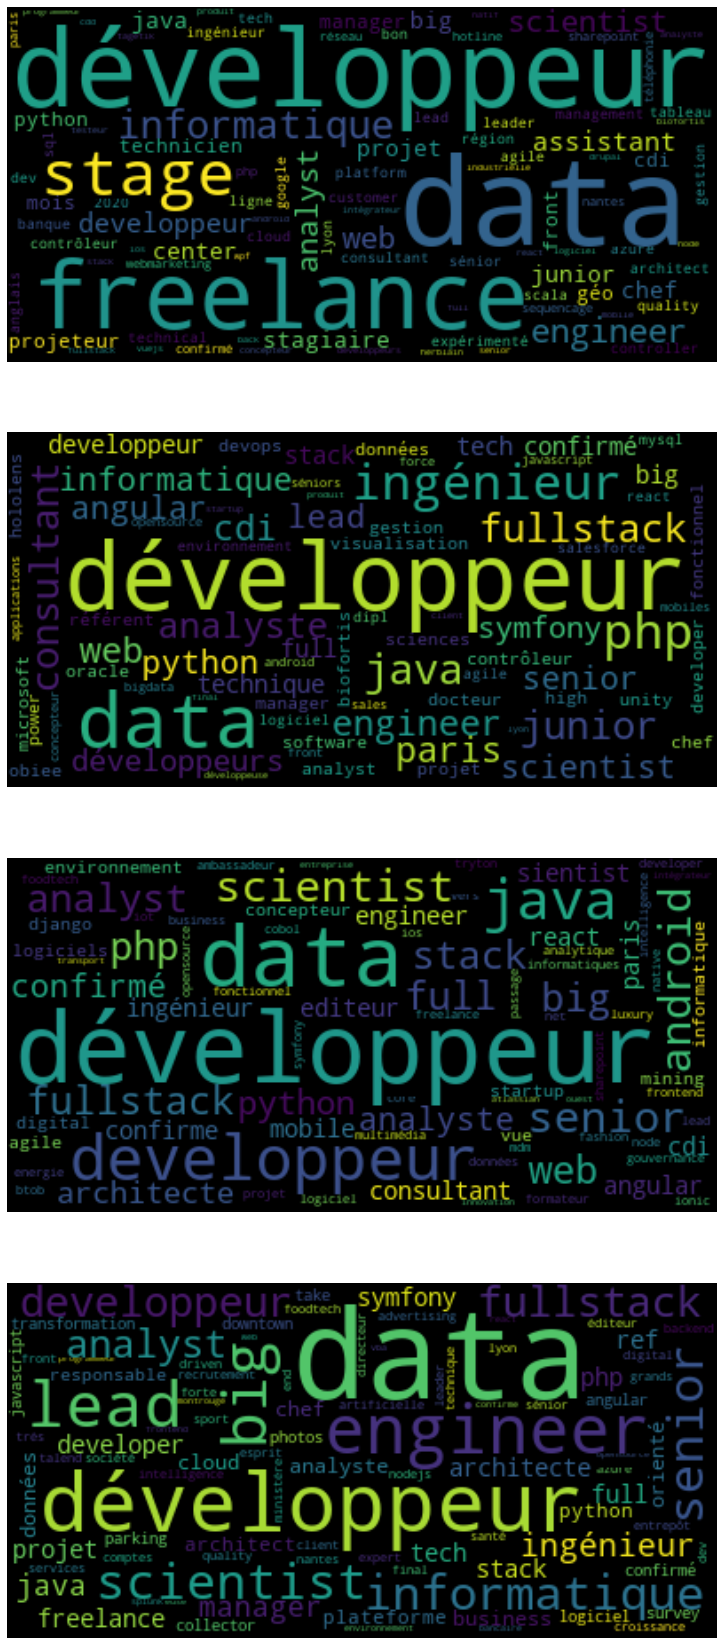

In [29]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize = (25, 30))

plt.figure(1)
plt.subplot(4, 1, 1)
plt.imshow(wordcloud_0, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 2)
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 3)
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 4)
plt.imshow(wordcloud_3, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
df_salary[df_salary['Title'].str.contains('Freelance')]

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_mean,salary_label,label_salary_min
3,p_9ba1a3ab379e9b6e,Data Engineer (H/F) / Freelance,Human Job,Paris (75),500 € par mois,Soutenir le développement de la plateforme BIG...,07/10/2019,Data,75,Paris,75,6000.0,6000.0,6000.0,0,0
4,p_8ccc668de734a40e,Data Engineer (H/F) / Freelance,HR-TEAM,Paris (75),500 € - 650 € par mois,Contexte : Nous recherchons aujourd’hui plusie...,07/10/2019,Data,75,Paris,75,6000.0,7800.0,6900.0,0,0
78,p_304ec1611bf99c34,Data scientist / Freelance,INFOTEL CONSEIL,Paris (75),520 € par semaine,Nous recherchons pour l’un de nos clients basé...,04/10/2019,Data,75,Paris,75,27040.0,27040.0,27040.0,0,0
93,p_4d857897fd7c92aa,Consultant Expérimenté - Data Quality H/F / Fr...,Thiveo,Paris (75),600 € par semaine,"L’un de nos clients, dans le secteur bancaire,...",04/10/2019,Data,75,Paris,75,31200.0,31200.0,31200.0,0,1
170,p_9f9f1edc2b9cf0f3,Data Engineer Azure / Freelance,AIM CONSULTING,Paris (75),450 € par semaine,Nous recherchons pour l’un de nos clients situ...,02/10/2019,Data,75,Paris,75,23400.0,23400.0,23400.0,0,0
181,p_d9523fdc354703df,Data Technical Leader Google Cloud Platform / ...,OZITEM,Paris (75),550 € par mois,Je recherche aujourd’hui un Data Technical Lea...,02/10/2019,Data,75,Paris,75,6600.0,6600.0,6600.0,0,0
226,p_b974f66542f8f953,Data Engineer / Banque en ligne / Freelance,AMETIX,Paris (75),500 € par mois,Le Data Engineer intervient auprès des équipes...,01/10/2019,Data,75,Paris,75,6000.0,6000.0,6000.0,0,0
288,pj_9378978b24a0ce53,Tech Lead BIG DATA - REF K - Freelance H/F,TEAM CONSULTING SARL,Paris (75),300 € - 500 € par jour,"Pour un de nos clients grand-comptes, nous rec...",NaN,Data,75,Paris,75,300.0,NaN,NaN,3,0
296,p_ff55a22d7ecb3d48,Data Engineer Sénior / Freelance,Cherry Pick,Paris (75),700 € par mois,Cherry Pick recherche pour l’un de ses clients...,30/09/2019,Data,75,Paris,75,8400.0,8400.0,8400.0,0,0
301,p_feec14496bca74e9,QA Data h/f / Freelance,Thiveo,Paris (75),600 € par mois,L’un de mes clients dans le secteur des termin...,27/09/2019,Data,75,Paris,75,7200.0,7200.0,7200.0,0,0


### Création de la fonction qui retourne les mots relevants sur la colonne desc

In [31]:
def clean_summary(desc):
    desc = word_tokenize(desc)
    #desc = [word.lower() for word in desc if word.isalpha() and len(word)>2]
    desc = [word.lower() for word in desc if (word.isalpha() or word.isdigit()) and len(word)>2]
    desc = [word for word in desc if (word not in stop_words_en) and (word not in stop_words_fr)]
    return desc

In [32]:
#stopwords
stop_words_en = stopwords.words('english')
stop_words_fr = stopwords.words('french')

### on applique la fonction sur chaque df salary

In [33]:
tag_desc_0 = label_0["Description"].apply(clean_summary)
tag_desc_1 = label_1["Description"].apply(clean_summary)    
tag_desc_2 = label_2["Description"].apply(clean_summary)
tag_desc_3 = label_3["Description"].apply(clean_summary)

In [34]:
tag_desc_3

1       [technology, domains, kafka, spark, python, ja...
24      [intrigué, potentiel, facebook, recrutement, v...
29      [areas, data, science, media, effectiveness, r...
89      [python, business, analysis, analyse, fonction...
105     [propos, monde, demain, entre, mains, rejoigne...
                              ...                        
1340    [descriptif, societe, cette, créé, 2018, récem...
1430    [opérateur, énergie, présent, plus, pays, enga...
1438    [expectra, leader, france, spécialisé, recrute...
1447    [contexte, recherche, entreprise, ambiance, co...
1538    [poste, missions, cadre, fort, développement, ...
Name: Description, Length: 70, dtype: object

# création des dictionnaires qui à chaque mot associe sa frequence

In [35]:
desc_0 = tag_desc_0.apply(Counter).sum().items()
desc_0 = sorted(desc_0, key=lambda kv : kv[1], reverse=True) 
dict_desc_0 = {k: v for k,v in desc_0}


desc_1 = tag_desc_1.apply(Counter).sum().items()
desc_1 = sorted(desc_1, key=lambda kv : kv[1], reverse=True) 
dict_desc_1 = {k: v for k,v in desc_1}

desc_2 = tag_desc_2.apply(Counter).sum().items()
desc_2 = sorted(desc_2, key=lambda kv : kv[1], reverse=True) 
dict_desc_2 = {k: v for k,v in desc_2}

desc_3 = tag_desc_3.apply(Counter).sum().items()
desc_3 = sorted(desc_3, key=lambda kv : kv[1], reverse=True) 
dict_desc_3 = {k: v for k,v in desc_3}

# Visualisation du wordcloud job_desc pour chaque df

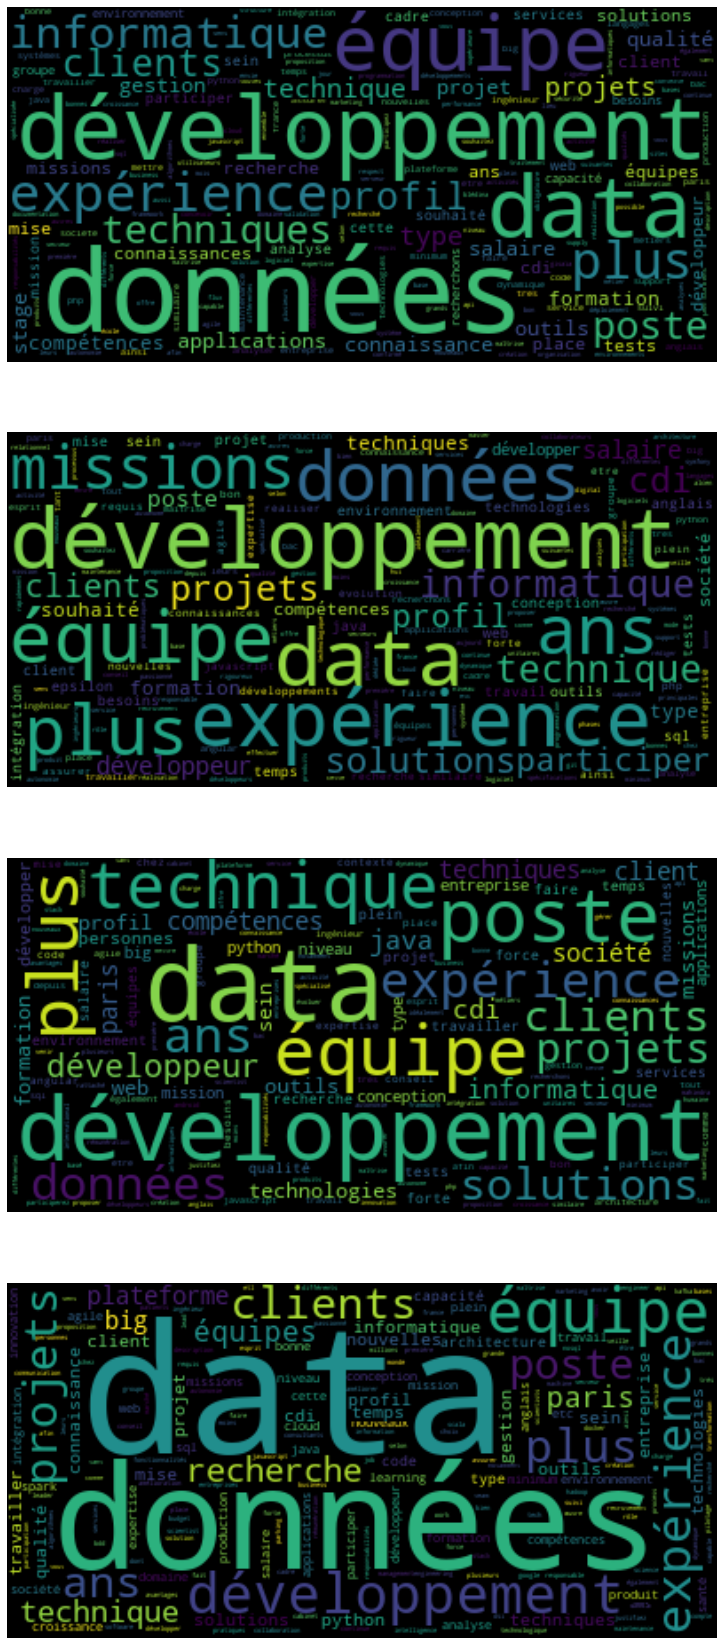

In [36]:
wordcloud5 = WordCloud().generate_from_frequencies(dict_desc_0)
wordcloud6 = WordCloud().generate_from_frequencies(dict_desc_1)
wordcloud7 = WordCloud().generate_from_frequencies(dict_desc_2)
wordcloud8 = WordCloud().generate_from_frequencies(dict_desc_3)

figure = plt.figure(figsize = (25, 30))
plt.figure(1)
plt.subplot(4, 1, 1)
plt.imshow(wordcloud5, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 2)
plt.imshow(wordcloud6, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 3)
plt.imshow(wordcloud7, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 4)
plt.imshow(wordcloud8, interpolation="bilinear")
plt.axis("off")
plt.show()

# Prediction salaire avec job desc brut seulement

In [189]:
from sklearn.feature_extraction.text import CountVectorizer

- Choix du X_desc en le nettoyant pour ne pas avoir les infos salaire et choix du y

In [577]:
X_desc = df_annually.Description.str.replace("\n"," ").str.replace(r'\b\d\d\W?\d\d\d\b\W?(\d\d)?','').str.replace(r'\+',' plus ').str.replace(r'\b\d\W?\d\d\d\W?(\d\d)?\b','').str.replace(r'\b\d\d\W\d\d[kK]?\b','').str.replace(r'\b\d\d[kK]\W?','')
y = df_annually.salary_label

- choix des stopwords à utliser avec CountVectorizer

In [579]:
#stop_words_en.remove('an')
stop_words_en_fr = stop_words_en + stop_words_fr + ["h","f", "mois", "ci", "e", "salaire", "avoir"]

- Utilisation de CountVectorizer

In [791]:
cv = CountVectorizer(token_pattern = r'\b\w+\b',stop_words=stop_words_en_fr,  ngram_range=(1, 4), min_df = 2)
cv.fit(X_desc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=2,
                ngram_range=(1, 4), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='\\b\\w+\\b', tokenizer=None,
                vocabulary=None)

In [792]:
len(cv.get_feature_names())

56607

In [793]:
X_desc_trans = cv.transform(X_desc)
#X_desc_trans = pd.DataFrame(cv.transform(X_desc).todense(), columns=cv.get_feature_names())
#X_desc_trans

In [794]:
import numpy as np
#np.asmatrix(X_desc_trans)

In [795]:
#word_counts = X_desc_trans.sum(axis=0)
#word_counts.sort_values(ascending = False).head(20)

- Prédiction avec RandomForestClassifier

In [796]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(X_desc_trans, y, test_size=0.3, random_state=0, stratify=y)


rfc = RandomForestClassifier(300, random_state=0)
rfc.fit(X_train, y_train)

rfc.score(X_test,y_test)

0.5812807881773399

In [797]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = cv.get_feature_names()).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(50)

,feature,importance
25618,informatique,0.003623
6302,aws,0.003593
18200,développeur,0.003076
35071,paris,0.003014
41697,python,0.002597
14049,data,0.002544
55768,équipes,0.001895
14955,devops,0.001718
17502,développement,0.001643
46974,similaire 1,0.001604


In [673]:
#list(X_desc[X_desc.str.contains("10 ans")])

# Prédiction salaire avec Title seulement

In [674]:
X_title = df_annually.Title.str.replace("\n"," ").str.replace("/"," ")

In [675]:
cv2 = CountVectorizer( token_pattern=r'\b[^\d\W]+\b', stop_words=stop_words_en_fr, ngram_range=(1, 2))
cv2.fit(X_title)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='\\b[^\\d\\W]+\\b',
                tokenizer=None, vocabulary=None)

In [676]:
cv2.get_feature_names()

['accepté',
 'access',
 'access cdi',
 'acteur',
 'acteur leader',
 'adelia',
 'administrateur',
 'administrateur système',
 'administrateur systèmes',
 'administrateur sytèmes',
 'administration',
 'administration système',
 'adminsys',
 'adminsys linux',
 'affaires',
 'affaires expert',
 'affaires ia',
 'agence',
 'agence web',
 'agile',
 'agile nantes',
 'agile paris',
 'agile vue',
 'ambassadeur',
 'ambassadeur formateur',
 'analyst',
 'analyst administration',
 'analyst analyste',
 'analyst bi',
 'analyst cdi',
 'analyst chef',
 'analyst confirmé',
 'analyst crm',
 'analyst entrepôt',
 'analyst foodtech',
 'analyst junior',
 'analyst marketplace',
 'analyst mobile',
 'analyste',
 'analyste bi',
 'analyste cobol',
 'analyste developpeur',
 'analyste développeur',
 'analyste informatique',
 'analyste éditeur',
 'analytics',
 'analytics manager',
 'analytique',
 'android',
 'android indépendant',
 'android ios',
 'android web',
 'angular',
 'angular confirme',
 'angular editeur',
 'a

In [677]:
X_title_trans = cv2.transform(X_title)
#X_title_trans = pd.DataFrame(cv2.transform(X_title).todense(), columns=cv2.get_feature_names())
#X_title_trans

In [678]:
#word_counts2 = X_title_trans.sum(axis=0)
#word_counts2.sort_values(ascending = False).head(30)

In [679]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_title_trans, y, test_size=0.3, random_state=10, stratify=y)


rfc = RandomForestClassifier(50, random_state=0)
rfc.fit(X_train2, y_train2)

rfc.score(X_test2,y_test2)

0.4876847290640394

In [680]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = cv2.get_feature_names()).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(30)

,feature,importance
358,développeur,0.023966
207,data,0.016159
755,lead,0.014799
286,devops,0.011285
1059,senior,0.011002
471,engineer,0.010785
657,ingénieur,0.009973
622,informatique,0.009874
698,java,0.008786
798,manager,0.008729


# Prédiction salaire avec ville

In [681]:
df_annually.city.unique()

array(['Toulouse ', 'Bordeaux ', 'Paris', 'Lyon', 'Corbas ', 'Nantes ',
       'Pessac ', 'Limonest ', 'Portet-sur-Garonne ', 'Blagnac ',
       'Talence ', 'Villeneuve-lès-Bouloc ', 'Mérignac ', 'Marennes ',
       'Rillieux-la-Pape ', 'Canéjan ', 'Beauzelle ',
       "Saint-Didier-au-Mont-d'Or ", 'Villeurbanne ', 'Lissieu ',
       'Gradignan ', 'Treillières ', 'Loire-Atlantique', 'Limas ',
       'Rhône', 'Labège ', 'Saint-Pierre-de-Chandieu ', 'Saint-Nazaire ',
       'Ancenis ', 'Vénissieux ', 'Chassieu ', 'Dardilly ',
       'Saint-Orens-de-Gameville ', 'Bruges ', 'Brignais ',
       'Saint-Herblain ', 'Châteaubriant ', 'Francheville ', 'Bron ',
       'Carquefou ', 'Toussieu ', 'Charbonnières-les-Bains ',
       'Saint-Médard-en-Jalles ', 'Le Haillan ', 'Castanet-Tolosan ',
       "L'Union ", 'Tassin-la-Demi-Lune ', 'Écully '], dtype=object)

In [682]:
city_d = pd.get_dummies(df_annually.city)
X_city = city_d

X_train, X_test, y_train, y_test = train_test_split(X_city, y, test_size=0.3, random_state=0, stratify=y)

In [683]:
rfc = RandomForestClassifier(300, random_state=0)
rfc.fit(X_train, y_train)

rfc.score(X_test,y_test)

0.46798029556650245

In [684]:
X_city.columns

Index(['Ancenis ', 'Beauzelle ', 'Blagnac ', 'Bordeaux ', 'Brignais ', 'Bron ',
       'Bruges ', 'Canéjan ', 'Carquefou ', 'Castanet-Tolosan ',
       'Charbonnières-les-Bains ', 'Chassieu ', 'Châteaubriant ', 'Corbas ',
       'Dardilly ', 'Francheville ', 'Gradignan ', 'L'Union ', 'Labège ',
       'Le Haillan ', 'Limas ', 'Limonest ', 'Lissieu ', 'Loire-Atlantique',
       'Lyon', 'Marennes ', 'Mérignac ', 'Nantes ', 'Paris', 'Pessac ',
       'Portet-sur-Garonne ', 'Rhône', 'Rillieux-la-Pape ',
       'Saint-Didier-au-Mont-d'Or ', 'Saint-Herblain ',
       'Saint-Médard-en-Jalles ', 'Saint-Nazaire ',
       'Saint-Orens-de-Gameville ', 'Saint-Pierre-de-Chandieu ', 'Talence ',
       'Tassin-la-Demi-Lune ', 'Toulouse ', 'Toussieu ', 'Treillières ',
       'Villeneuve-lès-Bouloc ', 'Villeurbanne ', 'Vénissieux ', 'Écully '],
      dtype='object')

In [685]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_city.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False)

,feature,importance
28,Paris,0.391325
3,Bordeaux,0.066871
24,Lyon,0.061962
27,Nantes,0.060437
41,Toulouse,0.056672
23,Loire-Atlantique,0.030471
40,Tassin-la-Demi-Lune,0.024076
34,Saint-Herblain,0.022183
31,Rhône,0.019068
18,Labège,0.016786


In [686]:
from sklearn.model_selection import GridSearchCV
#n_estimators = np.linspace(start = 600 , stop = 1000, num = 8, dtype= int )
#n_estimators
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

param_grid = {'n_estimators': n_estimators}
grid = GridSearchCV(rfc, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )

The best parameters are {'n_estimators': 50} with a score of 46
Best estimator accuracy on test set 46.80 


In [687]:
df_annually.Department_Search.unique()

array(['Haute-Garonne', 'Gironde', '75', 'Rhône', 'Loire-Atlantique'],
      dtype=object)

In [688]:
depart_d = pd.get_dummies(df_annually.Department_Search)
X_depart = depart_d

X_train, X_test, y_train, y_test = train_test_split(X_depart, y, test_size=0.3, random_state=0, stratify=y)

n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

param_grid = {'n_estimators': n_estimators}
grid = GridSearchCV(rfc, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )

The best parameters are {'n_estimators': 50} with a score of 45
Best estimator accuracy on test set 44.83 


In [689]:
rfc = RandomForestClassifier(50, random_state=0)
rfc.fit(X_train, y_train)

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_depart.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False)

,feature,importance
0,75,0.551818
4,Rhône,0.172739
2,Haute-Garonne,0.120490
3,Loire-Atlantique,0.104565
1,Gironde,0.050389


In [690]:
df_annually.to_csv("df_annually.csv")

# Prediction avec les X_desc_trans, X_title_trans et X_city

- Feature types

In [691]:
print(type(X_desc_trans))
print(type(X_title_trans))
print(type(X_city))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.frame.DataFrame'>


- On convertit X_desc_trans et X_title_trans en DF pour pouvoir les concatener

In [692]:
X_desc_df = pd.DataFrame(X_desc_trans.todense(), columns=cv.get_feature_names())
X_title_df = pd.DataFrame(X_title_trans.todense(), columns=cv2.get_feature_names())
X_city_df = X_city.reset_index(drop = True)

In [693]:
X = pd.concat([X_desc_df, X_title_df, X_city_df], axis=1)

In [694]:
X_city

,Ancenis,Beauzelle,Blagnac,Bordeaux,Brignais,Bron,Bruges,Canéjan,Carquefou,Castanet-Tolosan,...,Saint-Pierre-de-Chandieu,Talence,Tassin-la-Demi-Lune,Toulouse,Toussieu,Treillières,Villeneuve-lès-Bouloc,Villeurbanne,Vénissieux,Écully
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
15,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [695]:
X

,0,0 2,0 2 ans,0 2 ans paris,0 2 ans poste,000,000 inscrits,000 inscrits plus,000 inscrits plus 750,000 iziworkers,...,Saint-Pierre-de-Chandieu,Talence,Tassin-la-Demi-Lune,Toulouse,Toussieu,Treillières,Villeneuve-lès-Bouloc,Villeurbanne,Vénissieux,Écully
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 - Application du PCA

In [730]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

pca = PCA(.95)
pca.fit(X_train)
x_train_pca = pca.transform(X_train)
x_test_pca = pca.transform(X_test)

print ("On est passé de {} colonnes à {} colonnes".format(X.shape[1],len(pca.explained_variance_ratio_)))

On est passé de 57937 colonnes à 357 colonnes


- Logistic sans PCA

In [731]:
logistic = LogisticRegression(random_state =0)
logistic.fit(X_train, y_train)
print("L'accuracy est de {:.2f} %".format(logistic.score(X_test,y_test)*100))

/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


L'accuracy est de 60.36 %


In [732]:
logistic.score(X_train, y_train) * 100

100.0

In [733]:
feature_importances = pd.DataFrame(logistic.coef_[0],
                                   index = X_train.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(50)

,feature,importance
7979,cadre,0.292589
52777,type,0.275806
25618,informatique,0.274802
25088,idéalement,0.242152
57930,Toulouse,0.235499
32788,nantes,0.233369
44604,réaliser,0.230866
51177,temps plein cdi expérience,0.226094
37327,plein cdi expérience,0.226094
8580,cdi expérience,0.222727


- logistic avec PCA

In [734]:
logistic.fit(x_train_pca, y_train)
print("L'accuracy est de {:.2f} %".format(logistic.score(x_test_pca,y_test)*100))

/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


L'accuracy est de 59.76 %


In [735]:
logistic.score(x_train_pca, y_train) * 100

99.80237154150198

- SVM grid search sans PCA

In [736]:
kernel = ["linear", "poly", "rbf","sigmoid"]

svc=SVC(gamma='auto')

param_grid = {'kernel': kernel}
grid = GridSearchCV(svc, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )

The best parameters are {'kernel': 'linear'} with a score of 51
Best estimator accuracy on test set 56.80 


In [737]:
grid.best_estimator_.score(X_train, y_train)*100

1.0

- SVM grid avec PCA

In [738]:
grid.fit(x_train_pca, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(x_test_pca, y_test) * 100 ) )

The best parameters are {'kernel': 'sigmoid'} with a score of 53
Best estimator accuracy on test set 56.21 


In [739]:
grid.best_estimator_.score(x_train_pca, y_train) * 100

76.08695652173914

- Random forest classifier sans PCA

In [740]:
n_estimators = [200, 250, 300, 350, 400, 450, 500]

param_grid = {'n_estimators': n_estimators}
grid = GridSearchCV(rfc, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )

The best parameters are {'n_estimators': 450} with a score of 59
Best estimator accuracy on test set 59.76 


In [741]:
feature_importances = pd.DataFrame(grid.best_estimator_.feature_importances_,
                                   index = X_train.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(50)

,feature,importance
57917,Paris,0.007291
25618,informatique,0.003799
56965,développeur,0.003330
14049,data,0.002989
35071,paris,0.002685
18200,développeur,0.002408
56814,data,0.001948
41697,python,0.001786
25951,infrastructure,0.001673
14685,description emploi,0.001653


In [742]:
print(grid.best_estimator_.score(X_train, y_train) * 100)

100.0


- Random Forest Classifier avec PCA

In [743]:
grid.fit(x_train_pca, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(x_test_pca, y_test) * 100 ) )

The best parameters are {'n_estimators': 400} with a score of 46
Best estimator accuracy on test set 55.62 


In [744]:
print(grid.best_estimator_.score(x_train_pca, y_train) * 100)

100.0


- Adaboost sans PCA

In [745]:
from sklearn.ensemble import AdaBoostClassifier

adclassifier= AdaBoostClassifier()

n_estimators = [25, 50, 75, 100, 125, 150, 175, 200]

param_grid = {'n_estimators': n_estimators}

grid = GridSearchCV(adclassifier, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )

/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are {'n_estimators': 25} with a score of 46
Best estimator accuracy on test set 40.24 


In [746]:
print(grid.best_estimator_.score(X_train, y_train) * 100)

52.76679841897233


- Gradient Boosting classifier

In [747]:
from sklearn.ensemble import GradientBoostingClassifier
    
gbclf = GradientBoostingClassifier()

n_estimators = [25, 50, 75, 100, 125]

param_grid = {'n_estimators': n_estimators}

grid = GridSearchCV(gbclf, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(x_train_pca, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(x_test_pca, y_test) * 100 ) )

/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are {'n_estimators': 125} with a score of 46
Best estimator accuracy on test set 53.25 


In [748]:
print(grid.best_estimator_.score(x_train_pca, y_train) * 100)

100.0
